# CITP一覧ページの分析
情報処理学会のCITP一覧ページ https://www.ipsj.or.jp/CITPholders.html の内容を分析、可視化する。

### 必要なライブラリのインポート

In [132]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import re
import plotly.express as px

情報処理学会の一覧ベージからHTMLファイルを取得し、BeautifulSoupを用いて構文解析する。

In [133]:
r = requests.get('https://www.ipsj.or.jp/CITPholders.html')
r.encoding = r.apparent_encoding
soup = BeautifulSoup(r.text, 'html.parser')

構文解析したHTMLの内容から、必要な情報を抜き出し、pandasのデータフレームに格納する。

In [154]:
df = pd.DataFrame(columns=["Number", "Company", "Name"]) 
named = 0
for i in soup.select("ul.citplist li"):
    tmp = i.get("title").split("/")
    number = tmp[1]
    company = tmp[0]
    df = df.append({"Number": number, "Company": company, "Name": i.text}, ignore_index=True)
    named += 1
print("氏名を公表しているCITPの人数: {}".format(named))
# 「氏名の公開を希望しない認定情報技術者の認定番号」以降の番号を取得する
only_number_div = soup.find('div', attrs={'style': 'width : 550px;'})
unnamed = 0
pattern = re.compile('[0-9]{8}') # 8桁の数字でできた文字列にマッチするパターン
for l in only_number_div.get_text().split("\r\n"):
    if pattern.match(l):
        # 会社名と氏名は空としてdfに追加しておく
        df = df.append({"Number": l, "Company": "", "Name": ""}, ignore_index=True) 
        unnamed += 1
print("「氏名を公表していないCITPの人数: {}".format(unnamed))
print("合計: {}".format(named + unnamed))
print("公表している人の割合: {}".format(named/(named+unnamed)))
df

氏名を公表しているCITPの人数: 2265
「氏名を公表していないCITPの人数: 5018
合計: 7283
公表している人の割合: 0.31099821502128244


,Number,Company,Name
0,18001016,（株）日立製作所,相澤 裕千
1,20000228,株式会社 日立製作所,相本 昌幸
2,17000582,ニッセイ情報テクノロジー株式会社,阿江 邦章
3,16001181,エヌ・ティ・ティ・コムウェア（株）,青井 智史
4,20000071,エヌ・ティ・ティ・コムウェア株式会社,青木 栄介
...,...,...,...
7278,20000221,,
7279,20000223,,
7280,20000255,,
7281,20000265,,


Companyカラムにどのような項目が含まれているか、重複を除いて表示する。

In [135]:
set(df["Company"])

{'',
 '(株)日立製作所',
 '(株)日立製作所 社会ビジネスユニット 社会システム事業部 企画本部 企画部',
 'CCアーキテクト株式会社',
 'JCCソフト株式会社',
 'NECソリューションイノベータ株式会社',
 'NTTテクノクロス株式会社',
 'NTTテクノクロス（株）',
 'NTT西日本',
 'S&J（株）',
 'みずほ信託銀行',
 'みずほ情報総研 株式会社',
 'みずほ情報総研株式会社',
 'みずほ銀行',
 'アイテック阪急阪神株式会社',
 'アジア航測株式会社',
 'アルプスアルパイン株式会社',
 'インテグレーションテクノロジー株式会社',
 'イー・フォース株式会社',
 'エクセディア・コンサルティング株式会社',
 'エヌ・ティ・ティ・コムウェア株式会社',
 'エヌ・ティ・ティ・コムウェア（株）',
 'エリクソン・ジャパン株式会社',
 'コンピュートロン株式会社',
 'ソフトバンク・テクノロジー株式会社',
 'ソフトバンク（株）',
 'トヨタ自動車㈱',
 'ニッセイ情報テクノロジー株式会社',
 'ニッセイ情報テクノロジー（株）',
 'ハルコム',
 'リコーITソリューションズ株式会社',
 '㈱日立製作所',
 '三井物産セキュアディレクション株式会社',
 '三倉エンジニアリング株式会社',
 '三菱電機インフォメーションシステムズ（株）',
 '三菱電機インフォメーションシステム（株）',
 '三菱電機マイコン機器ソフトウエア株式会社',
 '三菱電機（株）',
 '京セラ株式会社',
 '力武健次技術士事務所',
 '吉川技術士事務所',
 '坂東技術士事務所',
 '大脇技術士事務所',
 '大阪府警察本部',
 '太平洋工業株式会社',
 '学校法人山脇学園',
 '富士通株式会社',
 '富士通（株）',
 '日本工営株式会社',
 '日本電技株式会社',
 '日本電気株式会社',
 '日本電気（株）',
 '日本ＮＣＲ株式会社',
 '日立製作所',
 '有限会社 Ovum Software',
 '東京ガスｉネット株式会社',
 '東芝インフラシステムズ株式会社',
 '東芝デジタルソリューションズ株式会社',
 '松下技術士事務所',
 '柏原コンサルティングオフィ

会社名の表記を統一するための辞書を作成する。

In [136]:
replace_table = {
'': '非公開',
'(株)日立製作所': '日立製作所',
 '(株)日立製作所 社会ビジネスユニット 社会システム事業部 企画本部 企画部': '日立製作所',
 'CCアーキテクト株式会社': 'CCアーキテクト',
 'JCCソフト株式会社':  'JCCソフト',
 'NECソリューションイノベータ株式会社': 'NECソリューションイノベータ',
 'NTTテクノクロス株式会社': 'NTTテクノクロス',
 'NTTテクノクロス（株）':'NTTテクノクロス',
 'S&J（株）': 'S&J',
 'みずほ情報総研 株式会社': 'みずほ情報総研',
 'みずほ情報総研株式会社': 'みずほ情報総研',
 'アイテック阪急阪神株式会社': 'アイテック阪急阪神',
 'アジア航測株式会社': 'アジア航測',
 'アルプスアルパイン株式会社': 'アルプスアルパイン',
 'インテグレーションテクノロジー株式会社': 'インテグレーションテクノロジー',
 'イー・フォース株式会社': 'イー・フォース',
 'エクセディア・コンサルティング株式会社': 'エクセディア・コンサルティング',
 'エヌ・ティ・ティ・コムウェア株式会社': 'エヌ・ティ・ティ・コムウェア',
 'エヌ・ティ・ティ・コムウェア（株）': 'エヌ・ティ・ティ・コムウェア',
 'エリクソン・ジャパン株式会社': 'エリクソン・ジャパン',
 'コンピュートロン株式会社': 'コンピュートロン',
 'ソフトバンク・テクノロジー株式会社': 'ソフトバンク・テクノロジー',
 'ソフトバンク（株）': 'ソフトバンク',
 'トヨタ自動車㈱': 'トヨタ自動車',
 'ニッセイ情報テクノロジー株式会社': 'ニッセイ情報テクノロジー',
 'ニッセイ情報テクノロジー（株）': 'ニッセイ情報テクノロジー',
 'リコーITソリューションズ株式会社': 'リコーITソリューションズ',
 '㈱日立製作所': '日立製作所',
 '三井物産セキュアディレクション株式会社': '三井物産セキュアディレクション',
 '三倉エンジニアリング株式会社': '三倉エンジニアリング',
 '三菱電機インフォメーションシステムズ（株）': '三菱電機インフォメーションシステムズ',
 '三菱電機インフォメーションシステム（株）': '三菱電機インフォメーションシステムズ',
 '三菱電機マイコン機器ソフトウエア株式会社': '三菱電機マイコン機器ソフトウエア',
 '三菱電機（株）': '三菱電機',
 '京セラ株式会社': '京セラ',
 '太平洋工業株式会社': '太平洋工業',
 '学校法人山脇学園': '山脇学園',
 '富士通株式会社': '富士通',
 '富士通（株）': '富士通',
 '日本工営株式会社': '日本工営',
 '日本電技株式会社': '日本電技',
 '日本電気株式会社': 'NEC',
 '日本電気（株）': 'NEC',
 '日本ＮＣＲ株式会社': '日本ＮＣＲ',
 '有限会社 Ovum Software': 'Ovum Software',
 '東京ガスｉネット株式会社': '東京ガスｉネット',
 '東芝インフラシステムズ株式会社': '東芝インフラシステムズ',
 '東芝デジタルソリューションズ株式会社': '東芝デジタルソリューションズ',
 '株式会社 日立産機システム': '日立産機システム',
 '株式会社 日立製作所': '日立製作所',
 '株式会社SHIFT': 'SHIFT',
 '株式会社\u3000中電シーティーアイ': '中電シーティーアイ',
 '株式会社\u3000日立ソリューションズ・クリエイト': '日立ソリューションズ・クリエイト',
 '株式会社\u3000日立製作所': '日立製作所',
 '株式会社\u3000関電システムズ': '関電システムズ',
 '株式会社クリモトビジネスアソシエイツ': 'クリモトビジネスアソシエイツ',
 '株式会社スクウェア・エニックス': 'スクウェア・エニックス',
 '株式会社ソフトウェアコントロール': 'ソフトウェアコントロール',
 '株式会社タクマ': 'タクマ',
 '株式会社デンソー': 'デンソー',
 '株式会社ファースト': 'ファースト',
 '株式会社マクニカ': 'マクニカ',
 '株式会社リコー': 'リコー',
 '株式会社中電シーティーアイ': '中電シーティーアイ',
 '株式会社山下設計': '山下設計',
 '株式会社日立システムズ': '日立システムズ',
 '株式会社日立製作所': '日立製作所',
 '株式会社電通国際情報サービス': '電通国際情報サービス',
 '株式会社ＬＳＥＴ': 'ＬＳＥＴ',
 '沖電気工業株式会社': '沖電気工業',
 '独立行政法人\u3000国立高専機構\u3000東京工業高等専門学校': '東京工業高等専門学校',
 '（株）CIJ': 'CIJ',
 '（株）インテック': 'インテック',
 '（株）デジタルフィールド': 'デジタルフィールド',
 '（株）ハイマックス': 'ハイマックス',
 '（株）フィリップス・ジャパン': 'フィリップス・ジャパン',
 '（株）ラック': 'ラック',
 '（株）中電シーティーアイ': '中電シーティーアイ',
 '（株）日立制作所': '日立製作所',
 '（株）日立製作所': '日立製作所',
 '（株）日立製作所→退職個人へ': '個人',
 '（株）野村総合研究所': '野村総合研究所',
 'ＮＤＳ株式会社': 'ＮＤＳ',
}

上の辞書を用いてCompanyカラムの内容を置換し、再度内容を確認する。

In [137]:
df["Company"] = df["Company"].replace(replace_table)
set(df["Company"])

{'CCアーキテクト',
 'CIJ',
 'JCCソフト',
 'NEC',
 'NECソリューションイノベータ',
 'NTTテクノクロス',
 'NTT西日本',
 'Ovum Software',
 'S&J',
 'SHIFT',
 'みずほ信託銀行',
 'みずほ情報総研',
 'みずほ銀行',
 'アイテック阪急阪神',
 'アジア航測',
 'アルプスアルパイン',
 'インテグレーションテクノロジー',
 'インテック',
 'イー・フォース',
 'エクセディア・コンサルティング',
 'エヌ・ティ・ティ・コムウェア',
 'エリクソン・ジャパン',
 'クリモトビジネスアソシエイツ',
 'コンピュートロン',
 'スクウェア・エニックス',
 'ソフトウェアコントロール',
 'ソフトバンク',
 'ソフトバンク・テクノロジー',
 'タクマ',
 'デジタルフィールド',
 'デンソー',
 'トヨタ自動車',
 'ニッセイ情報テクノロジー',
 'ハイマックス',
 'ハルコム',
 'ファースト',
 'フィリップス・ジャパン',
 'マクニカ',
 'ラック',
 'リコー',
 'リコーITソリューションズ',
 '三井物産セキュアディレクション',
 '三倉エンジニアリング',
 '三菱電機',
 '三菱電機インフォメーションシステムズ',
 '三菱電機マイコン機器ソフトウエア',
 '中電シーティーアイ',
 '京セラ',
 '個人',
 '力武健次技術士事務所',
 '吉川技術士事務所',
 '坂東技術士事務所',
 '大脇技術士事務所',
 '大阪府警察本部',
 '太平洋工業',
 '富士通',
 '山下設計',
 '山脇学園',
 '日本工営',
 '日本電技',
 '日本ＮＣＲ',
 '日立システムズ',
 '日立ソリューションズ・クリエイト',
 '日立産機システム',
 '日立製作所',
 '東京ガスｉネット',
 '東京工業高等専門学校',
 '東芝インフラシステムズ',
 '東芝デジタルソリューションズ',
 '松下技術士事務所',
 '柏原コンサルティングオフィス',
 '沖電気工業',
 '石川Ｅ＆ＩＴ技術士事務所',
 '神戸学院大学',
 '野村総合研究所',
 '鍜治技術士事務所',
 '関電システム

会社ごとのCITP所有者の数を集計し、上位20位を表示する。

In [138]:
df["Company"].value_counts().head(20)

非公開                   5066
エヌ・ティ・ティ・コムウェア         853
ニッセイ情報テクノロジー           445
日立製作所                  389
三菱電機インフォメーションシステムズ     292
NTTテクノクロス               57
リコーITソリューションズ           53
中電シーティーアイ               20
みずほ情報総研                 18
東芝インフラシステムズ              6
富士通                      4
NEC                      3
リコー                      3
野村総合研究所                  2
インテック                    2
日本工営                     2
ラック                      2
三菱電機マイコン機器ソフトウエア         1
松下技術士事務所                 1
みずほ銀行                    1
Name: Company, dtype: int64

「非公開」ではなく、複数のCITPが存在する会社のCITPの数を棒グラフで表示。

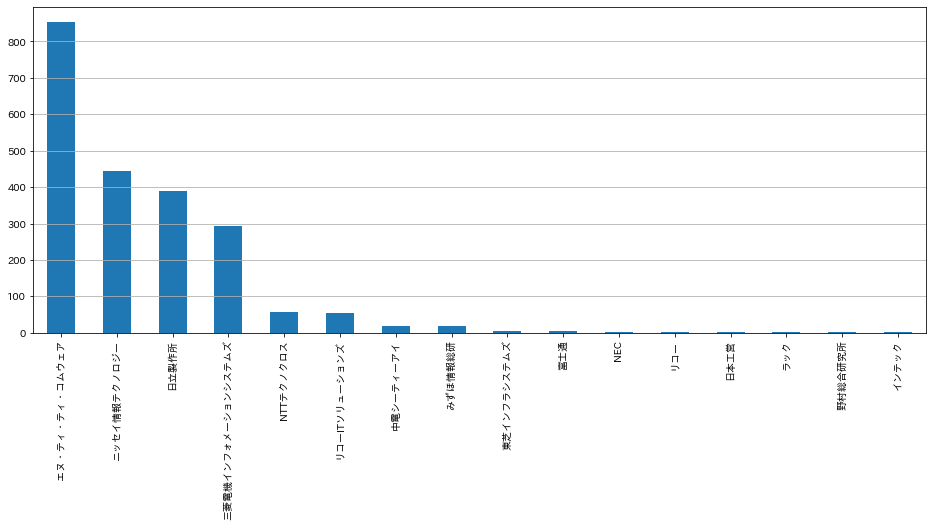

In [139]:
df_company_num = df.query('Company != "非公開"')["Company"].value_counts()

fig = plt.figure(figsize=(16.0, 6.0))
ax = fig.add_subplot(111)
ax = df_company_num[df_company_num>1].plot(kind='bar')
ax.grid(axis="y")

plt.show()


In [140]:
def get_year_by_number(num):
    return 2000 + int(num[:2])

df["Year"] = df["Number"].apply(get_year_by_number)
df

,Number,Company,Name,Year
0,18001016,日立製作所,相澤 裕千,2018
1,20000228,日立製作所,相本 昌幸,2020
2,17000582,ニッセイ情報テクノロジー,阿江 邦章,2017
3,16001181,エヌ・ティ・ティ・コムウェア,青井 智史,2016
4,20000071,エヌ・ティ・ティ・コムウェア,青木 栄介,2020
...,...,...,...,...
7278,20000221,非公開,,2020
7279,20000223,非公開,,2020
7280,20000255,非公開,,2020
7281,20000265,非公開,,2020


In [141]:
df["Year"].value_counts().sort_index()

2013       4
2014       9
2015     158
2016    3814
2017     544
2018    1981
2019     443
2020     330
Name: Year, dtype: int64

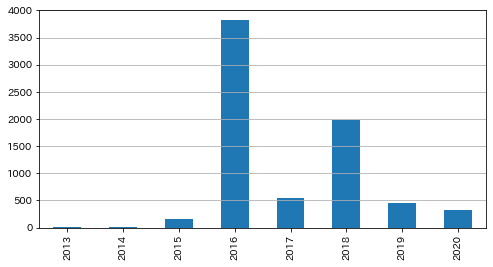

In [142]:
fig = plt.figure(figsize=(8.0, 4.0))
ax = fig.add_subplot(111)
ax = df["Year"].value_counts().plot(kind='bar')
ax.grid(axis="y")

plt.show()

### Plotly.pyで使いやすいようにデータを加工

In [143]:
size_company_year = df.groupby(["Year", "Company"]).size().to_frame().reset_index().melt(id_vars = ["Year", "Company"], value_name="Count")

In [144]:
size_company_year

,Year,Company,variable,Count
0,2013,フィリップス・ジャパン,0,1
1,2013,富士通,0,1
2,2013,日立製作所,0,2
3,2014,S&J,0,1
4,2014,ソフトバンク,0,1
...,...,...,...,...
112,2020,中電シーティーアイ,0,1
113,2020,吉川技術士事務所,0,1
114,2020,日本電技,0,1
115,2020,日立製作所,0,66


In [157]:
fig = px.bar(
    size_company_year,
    x = "Year",
    y = "Count",
    color = "Company",
)
with open("citp-company.html", "w") as f:
    f.write(fig.to_html(include_plotlyjs="cdn"))
fig.show()

### もっとも多くの組織からCITPが登録されたのは2019年度

In [146]:
size_company_year.groupby("Year").size()

Year
2013     3
2014     6
2015     6
2016     9
2017     8
2018     9
2019    61
2020    15
dtype: int64

### 中電シーティーアイは2014年以降、毎年CITPを輩出している

In [149]:
size_company_year.query('Company=="中電シーティーアイ"')[["Year","Count"]]

,Year,Count
7,2014,2
13,2015,2
21,2016,5
30,2017,5
36,2018,3
70,2019,2
112,2020,1


## このページの情報から読み取れる事

* このページで公開されているCITPの情報は7283人分
* そのうち7割にあたる約5000人は氏名や社名（組織）を公表していない
* もっとも多くのCITPを擁する組織は、エヌ・ティ・ティ・コムウェアの853人
* これまででCITPがもっとも増加したのは2016年度、ついで2018年度。
* もっとも多くの組織からCITPが登録されたのは2019年度
* 中電シーティーアイは2014年以降、毎年CITPを輩出している